The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Figure 6: the number of false positives for different widths and depths


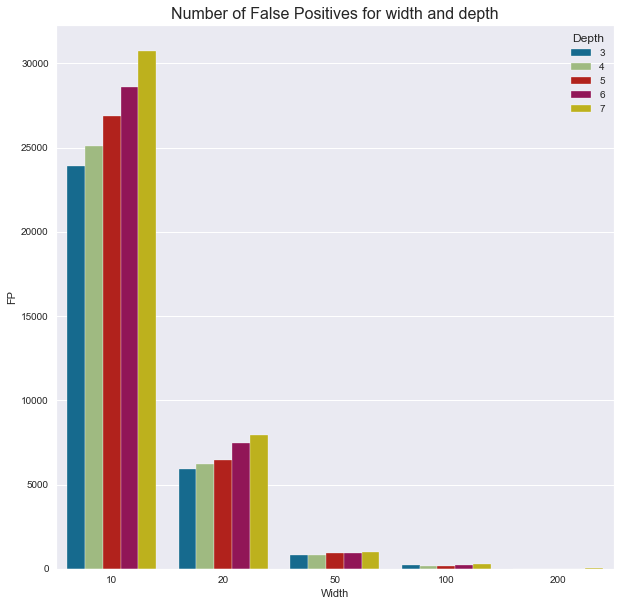

,Trigram,CM,Count,Extra_Frequency
Top,,,,
0,000,105637,105557,100.076
1,222,3457,3442,100.436
2,221,2943,2943,100
3,122,2824,2824,100
4,212,2597,2468,105.227
5,111,1637,1637,100
6,211,622,542,114.76
7,112,543,531,102.26
8,002,416,416,100


In [102]:
%reset -f
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sketching as sketch
import math

data = sketch.load_data("data/capture20110818.binetflow.txt")
pdata = sketch.pre_process(data)

# We first discretize the values for the features we selected in the discretization task. 
# We then make trigrams 
# Optimal number of bins for source address, based on elbow method
nbin_source_address = 3

# Discretize the source address values (after encoding them first)
discretized = pd.DataFrame()
discretized = pdata[['SourceAddress']].copy()
discretized["Protocol"] = sketch.encode_feature(pdata["Protocol"])
discretized["Protocol"], binsedges_infected = sketch.discretize_feature(discretized, "Protocol", nbin_source_address, "kmeans")

# Create 3-grams based on the descretized source address and of its two predecessors
discretized["trigram"] = 0
discretized.trigram.iloc[0] = str(discretized.Protocol.iloc[0])+""+str(discretized.Protocol.iloc[0])+""+str(discretized.Protocol.iloc[0])
discretized.trigram.iloc[1] = str(discretized.Protocol.iloc[0])+""+str(discretized.Protocol.iloc[0])+""+str(discretized.Protocol.iloc[1])

for i in range(2,len(discretized)):
    discretized.trigram.iloc[i] = str(discretized.Protocol.iloc[i-2])+""+str(discretized.Protocol.iloc[i-1])+""+str(discretized.Protocol.iloc[i])

# Define possible values for error probability (δ) and error factor (ε).
# Higher width and depth implies a lower error.
deltas = [0.05, 0.025, 0.01, 0.0025, 0.001]
epsilons = [0.1, 0.05, 0.02, 0.01, 0.005]
combinations = [(i, j) for i in deltas for j in epsilons]

results = pd.DataFrame(columns=["Width","Depth","Delta","Epsilon","Trigram","CM","Count", "FP"])

# For each combination of delta and epsilon the sketch is computed
for delta, epsilon in combinations:
    # Calculate the width (possible values) and depth (hash functions)
    width = (int) (1/epsilon)
    depth = round((math.log(1/delta)))
    hash_values = [[0]*width]*depth

    # Compute the sketch by increasing the value for the corresponding hash function by one for each 3-gram
    for trigram in discretized.trigram:
        for i in range(depth):
            hash_values[i][sketch.hash_function(trigram,i,width)] += 1
    
    # For each unique trigram the number of COUNT-MIN value is computed and saved for evaluation
    for value in discretized.trigram.unique():
        hashes = [sketch.hash_function(value,x,width) for x in range(depth)]
        values = [0]*depth

        for h in range(depth):
            values[h] = hash_values[h][hashes[h]]
            
        fp = np.min(values)-len(discretized.loc[discretized["trigram"] == value])
        results = results.append({"Width": width, "Depth": depth, "Delta": delta,"Epsilon": epsilon,"Trigram": value,"CM": np.min(values),"Count": len(discretized.loc[discretized["trigram"] == value]), "FP": fp}, ignore_index=True)
        
# Group the results for the FP count
grouped_results = results.groupby(['Width','Depth']).agg({'FP':'sum'}).reset_index()

# Plot the results for each combination of width and depth
print("Figure 6: the number of false positives for different widths and depths")
fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(x="Width",y="FP",hue="Depth",data=results, ci=None, ax=ax)
ax.set_title("Number of False Positives for width and depth", size=16)
plt.show()

# Choose a suitable width and depth based on the results and obtain the frequencies for the top10 3-grams
filter_results = results.loc[(results["Width"] == 100) & (results["Depth"] == 4)].sort_values(by=['Count'], ascending=False)
filter_results["FP"] = filter_results["CM"]-filter_results["Count"]
filter_results["Extra_Frequency"] = filter_results["CM"]/filter_results["Count"]*100
top_trigrams = filter_results[["Trigram","CM","Count","Extra_Frequency"]].reset_index()
top_trigrams.index.name = "Top"
top_trigrams[["Trigram","CM","Count","Extra_Frequency"]].head(10)

In [67]:
grouped_results.head(60)

,Width,Depth,FP
0,10,3,1981099
1,10,4,2505287
2,10,5,2947293
3,10,6,3459626
4,10,7,4362703
5,20,3,835515
6,20,4,988214
7,20,5,1103937
8,20,6,1318281
9,20,7,1583091


In [92]:
# Choose a suitable width and depth based on the results and obtain the frequencies for the top 10 3-grams
filter_results = results.loc[(results["Width"] == 100) & (results["Depth"] == 4)].sort_values(by=['Count'], ascending=False)
filter_results["FP"] = filter_results["CM"]-filter_results["Count"]
filter_results["Extra_Approximated"] = filter_results["CM"]/filter_results["Count"]*100
top_trigrams = filter_results[["Trigram","CM","Count","FP","Extra_Approximated"]].reset_index()
top_trigrams.index.name = "Top"
top_trigrams[["Trigram","CM","Count","FP","Extra_Approximated"]].head(10)

,Trigram,CM,Count,FP,Extra_Approximated
Top,,,,,
0,222,23865,21881,1984,109.067
1,000,17408,16365,1043,106.373
2,111,12179,12155,24,100.197
3,101,5875,5875,0,100
4,110,5782,5782,0,100
5,011,5774,5774,0,100
6,121,4498,4435,63,101.421
7,211,6023,4357,1666,138.237
8,112,6358,4351,2007,146.127


In [83]:
row = 0
for i,j in zip(top_trigrams.Count, top_trigrams.CM):
    if row < 11:
        print(j-i)
    
    row += 1
        

0
5
1
0
0
0
0
0
0
19
0


COUNT-MIN sketches are very good applicable to continuous streams of data. They reflect an approximation of the real data in the streams in sub-linear space, in which the approximation differs because of the chosen variables of width and depth. As with discretization, it uses only a fraction of the distinct values. The width and depth (number of distinct hash functions) variables depend on the error probability (δ) and error factor (ε). The width is equal to the inverse of the error factor (1/ε) and the depth is equal the logarithm of the inverse of the error probability (log(1/δ)). The hash functions must be pair-wise independent to prevent hash collisions in the profiles. This independence is preserved using gi(x) = h1(x) + i*h2(x), described in [2]. The 3-gram profiles are built by concatenating the discretized values of the protocol, duration and source bytes features. 

We expect that the higher the width and depth, the less false positives should appear because the probability of a collision is lower. Simply choosing a very high width and depth contradicts the use of sketching since this method aims to lower the width and depth. We therefore must find a good trade-off in false positives and width and depth.

What we observe from the results is that for a width of 10 the number of false positives is enormous (see Figure 6). Increasing the width from 20 to 50 increases the accuracy significantly, but still having a lot FP. For a width of at least 200 the number of false positives is very low, although this also increases the used memory significantly. We would like to choose a width and depth that is memory efficient with a low number of false positives. The biggest relative accuracy increase is obtained with a width of 100 and a depth of 4, 'only' storing 400 values, .

As said earlier, the COUNT-MIN sketch approximation is probablistic, which increases the accuracy by the use of a higher width and depth. The lower the width and depth, the more approximation errors arise. These approximation errors originate from collisions in the (3-gram) profiles. The more hash functions are used, the lower the probability that there exists hash collisions (overlap) with the same profile. However, this does not mean that the width and depth are independent from each other. If a lot of hash functions are used in combination with a low width, the probability of the same profiles as a result increase.

Using the chosen width and depth, we obtain the top 10 with their frequencies. We see that "222" is clearly the most frequent 3-gram, with no collisions in almost 100K occurences. We also see that there are relatively more collisions occur for the less frequent 3-grams.

[2] Less Hashing, Same Performance: Building a Better Bloom Filter. Adam Kirsch, Michael Mitzenmacher.

In [96]:
discretized.SourceIP.value_counts()

1    43440
2    42899
0    35743
3      117
Name: SourceIP, dtype: int64

In [63]:
nbin_source_address = 4

discretized = pd.DataFrame()
discretized = pdata[['SourceAddress']].copy()
discretized["SourceIP"] = sketch.encode_feature(discretized["SourceAddress"])
discretized["SourceIP"], binsedges_infected = sketch.discretize_feature(discretized, "SourceIP", nbin_source_address, "kmeans")

discretized["trigram"] = 0

discretized.SourceIP.iloc[0] = 1
discretized.trigram.iloc[0] = str(discretized.SourceIP.iloc[0])+""+str(discretized.SourceIP.iloc[0])+""+str(discretized.SourceIP.iloc[0])
discretized.trigram.iloc[1] = str(discretized.SourceIP.iloc[0])+""+str(discretized.SourceIP.iloc[0])+""+str(discretized.SourceIP.iloc[1])

for i in range(2,len(discretized)):
    discretized.trigram.iloc[i] = str(discretized.SourceIP.iloc[i-2])+""+str(discretized.SourceIP.iloc[i-1])+""+str(discretized.SourceIP.iloc[i])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [64]:

discretized_new.head(60)

,SourceAddress,SourceIP,trigram
407,147.32.84.164,1,111
697,147.32.84.164,0,110
717,147.32.84.164,0,100
896,147.32.84.170,0,000
897,147.32.84.170,0,000
898,147.32.84.170,0,000
1020,147.32.84.170,0,000
1021,147.32.84.170,0,000
1022,147.32.84.170,0,000
1279,147.32.84.164,0,000
